In [1]:
import os

In [2]:
# # data_frame.distrito.value_counts()
# # pd.to_datetime(data_frame.fecha[-1])
# # pd.to_datetime('')
# print(pd.to_datetime(data_frame.fecha.iloc[-1], format='%d/%m/%Y'))
# print(pd.to_datetime(octubre_2022.FX_DATOS_INI.iloc[-1], format='%Y-%m-%d'))

In [3]:
# agosto_2021 = pd.read_csv('/home/luis/Descargas/Rango_Edades_Seccion_202108.csv',delimiter=';')
# # octubre_2022.DESC_DISTRITO.value_counts()
# type(agosto_2021.FX_DATOS_INI[0])
# agosto_2021.FX_DATOS_INI[0]

In [4]:
# import tensorflow as tf
# import tensorflow_datasets as tfds
# from tensorflow.keras.models import Sequential

# from keras_fsl.models.encoders import BasicCNN
# from keras_fsl.layers import GramMatrix
# from keras_fsl.losses.gram_matrix_losses import BinaryCrossentropy
# from keras_fsl.metrics.gram_matrix_metrics import classification_accuracy, min_eigenvalue
# from keras_fsl.utils.tensors import get_dummies

# #%% Get data
# train_dataset, val_dataset, test_dataset = [
#     dataset.shuffle(1024).batch(64).map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), get_dummies(y)[0]))
#     for dataset in tfds.load(name="omniglot", split=["train[:90%]", "train[90%:]", "test"], as_supervised=True)
# ]

# input_shape = next(tfds.as_numpy(train_dataset.take(1)))[0].shape[1:]  # first shape is batch_size

# #%% Training
# encoder = BasicCNN(input_shape=input_shape)
# support_layer = GramMatrix(kernel="DenseSigmoid")
# model = Sequential([encoder, support_layer])
# model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[classification_accuracy(), min_eigenvalue])
# model.fit(train_dataset, validation_data=val_dataset, epochs=5)

[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img width='600px' src="Data/Data_flow.png"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [6]:
from datetime import datetime
import matplotlib.pyplot as plt

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['nb', 'svc', 'knn', 'logistic_regression', 'random_forest', 'mlp', 'convolution_1d', 'convolution_2d', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########
loaded_timestamp = '2023-03-26-20:53:54'

In [7]:
laptop = False
calculate_weights = True
tsne = False

madrid = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = not laptop
other_models = cnn1d = False
cnn1d = False
cnn2d = True
other_models = cnn1d = True

# calculate_cnn_hyperparams = True
calculate_cnn_hyperparams = False

In [8]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = False
# UK = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# # tree_method = 'gpu_hist'
# train_nn = False
# other_models = cnn1d = False

## Importar Tensorflow

In [9]:
# !pip install tensorflow-addons

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

2023-10-11 14:06:32.143220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 14:06:32.209037: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 14:06:32.226837: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 14:06:32.520819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [11]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# # !nvidia-smi

## Importador/Exportador JSON

In [12]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [13]:
from src.mixins.utils import get_feature_matrix_indexes
from src.mixins.utils import fv2gi
from src.mixins.utils import get_max_child_numbers
from src.mixins.utils import build_gray_images

## Construcción Feature Vector

In [14]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [15]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [16]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    # print('Slight: ', (Y_oversampled == 'Slight').sum())
    # print('Serious:', (Y_oversampled == 'Serious').sum())
    # print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    # print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    # print('********** After OverSampling **********')
    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Assistance:', (Y_oversampled == 'Assistance').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Algoritmo genético

In [17]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.2, 0.2],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-3, 3],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-4, 4],
                                                'round': 1
                                   }
                          }

number_of_individuals = 50
numberOfParentsMating = 10
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [18]:
from src.genetic_algorithm import generate_individual
from src.genetic_algorithm import initialize_population

### Fitness function

In [19]:
from src.genetic_algorithm import fitness_f1score

### Evaluación de población

In [20]:
def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
              'tree_method': 'auto',
              'single_precision_histogram': True,
              'num_class': 2
             }

    # params = {'objective':'binary:logistic',
    #           'tree_method': tree_method,
    #           'single_precision_histogram': True
    #          }
    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity = 0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5
        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

### Selección de padres

In [21]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [22]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [23]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [24]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## One-Hot Encoder/Decoder

In [25]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Serious': 1,
        'Fatal': 2
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 3)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Serious',
        2: 'Fatal'
    }   

    return Y_labels.replace(transf)

In [26]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Assistance': 1
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 2)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Assistance'
    }   

    return Y_labels.replace(transf)

## Visualización de datos

### Matriz de correlación

In [27]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [28]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [29]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [30]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## C-GAN

In [31]:
from tensorflow import keras

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None] # TASPCNN: shape=(None, 2, 1, 1)
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        ) # TASPCNN: shape=(None,)
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        ) # TASPCNN: shape=(None, 25, 25, 2)

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        ) # TASPCNN: shape=(None, 64)

        # Decode the noise (guided by labels) to fake images.
        #print(f"Random vector labels shape: {random_vector_labels.shape}")
        generated_images = self.generator(random_vector_labels) # TASPCNN: shape=(None, 20, 20, 1)
        #print(f"Generated images shape: {generated_images.shape}")

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## 1D-Convolution

In [32]:


# import tensorflow_addons as tfa

# lr_init = 0.1

# convolution_1d = models.Sequential()
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
# convolution_1d.add(layers.Flatten())
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Dense(units=128))
# convolution_1d.add(layers.BatchNormalization())
# convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )



### 3 Classes

In [33]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense, num_classes=2, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(3, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='categorical_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

### 2 Classes

In [34]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense,  num_classes=2, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(3, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

## TASP-CNN

In [35]:
# lr_init = 0.0001

# tasp_cnn = models.Sequential()
# tasp_cnn.add(layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 128)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 1024)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 32)))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 512)))
# tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 1024)))
# tasp_cnn.add(layers.Flatten())
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Dense(units=32))
# tasp_cnn.add(layers.Dropout(.5))
# tasp_cnn.add(layers.BatchNormalization())
# tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

# tasp_cnn.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

### 3 Classes

In [36]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, dense,  num_classes=2, dropout=0.2, learnRate=0.01):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_three)))
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='categorical_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

### 2 Classes

In [37]:
from src.models.convolutions import get_tasp_cnn_o

In [38]:
# tasp_cnn.summary()

In [39]:
print('Done!')

Done!


## Results

### F1-Score History

In [40]:
def plot_f1_score_history(f1_score_path, f1_score_name, history):
    figure_name = plt.figure(figsize=(20, 10))

    history.history['f1_score'].insert(0, 0)
    history.history['val_f1_score'].insert(0, 0)

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [41]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):

    labels = one_hot_to_casualty(y_true)

    report = classification_report(y_true,
                                   y_predicted,
                                   target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [43]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

In [44]:
print('Donee!')

Donee!


# Madrid Data

## Importación de datos

- [Web Dataset](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

- [Web documentación](https://datos.madrid.es/FWProjects/egob/Catalogo/Seguridad/Ficheros/Estructura_DS_Accidentes_trafico_desde_2019.pdf)



In [45]:
loaded_timestamp = '2022-05-24-11:01:39'
model_version = '2022-05-17-20:07:36'

In [46]:
import pandas as pd
import random
import seaborn as sns

from src.data import read_madrid_data


city_name = 'madrid'
city = madrid

# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'

root_path = './Data/Madrid/'

data_frame = read_madrid_data(root_path)

### Calcular Vehículos implicados

A partir del número de expediente (un mismo expediente en varias filas quiere decir que se trata del mismo accidente) se hace un `groupby` a partir de él. Como el atributo `positiva_alcohol` no tiene valores nulos en ninguna de las filas, hacemos un conteo a partir de él y se asigna a una nueva columna `positiva_alcohol_rename` que posteriormente será renombrada como `vehiculos_implicados`

In [47]:
data_frame = data_frame.join(data_frame.groupby('num_expediente')['positiva_alcohol'].count(), on='num_expediente', rsuffix='_rename')
data_frame.rename(columns={"positiva_alcohol_rename": "vehiculos_implicados"}, errors="raise", inplace=True)
data_frame = data_frame.reset_index(drop=True)
# data_frame.localizacion.unique()[:1000]

## Limpieza de datos

### Clasificación de carreteras

In [48]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified


regex = {}
regex['parking'] = 'PK|P.K|parking'
regex['aeropuerto_regex'] = 'AEROPUERTO|AEROP'
regex['cuesta_regex'] = 'CUSTA|CUESTA'
regex['paseo_regex'] = 'PASEO|paseo'
regex['parque_regex'] = 'PARQUE|PQUE|RETIRO'
regex['tunel_regex'] = 'TUNEL|TÚNEL'
regex['poligono_regex'] ='POLIGONO'
regex['camino_regex']= 'CMNO|CAMINO'
regex['ronda_regex'] = 'RONDA'
regex['rotonda_regex'] = 'GTA|gta|GLORIETA|glorieta|ROTONDA|FUENT'
regex['puerta_regex'] = 'PUERTA|PTA|Puerta'
regex['puente_regex'] = 'PNTE|PUENTE'
regex['plaza_regex'] = 'PLAZA|PZA'
regex['bulevard_regex'] = 'BULE'
regex['travesia_regex'] = 'TRVA'
regex['calzada_regex'] = 'CALZADA'
regex['road_regex'] = 'CTRA.|CARRETERA|carretera|CRA.' # B
regex['avenida_regex'] = 'AVDA|AV|AVENIDA|AVDA|avenida|Avda.'
regex['highway_regex'] = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23|KILOMETRO' # A,A(M),Motorway
regex['calle_regex']  = 'CALL.|Calle|CALLE|c/|C/|C.|calle'

data_frame['tipo_via'] = 'N/A'

for index,regex_values in enumerate(regex.values()):
    
    print(regex_values)
    regex_indexes = data_frame[data_frame.localizacion.str.contains(regex_values,  case = True, regex=True)].index
    print(len(regex_indexes))
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('tipo_via')] = str(index)
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('localizacion')] = str(index)
    
    
    
# # street_indexes  = data_frame[data_frame.localizacion.str.contains('CALL.|Calle|CALLE|c/|C/|C.|calle', case = True, regex=True)].index
# # highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# # road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# # data_frame['tipo_via'] = 'N/A'

# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# # data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# # data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# # data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]


PK|P.K|parking
1907
AEROPUERTO|AEROP
157
CUSTA|CUESTA
237
PASEO|paseo
5677
PARQUE|PQUE|RETIRO
265
TUNEL|TÚNEL
382
POLIGONO
4
CMNO|CAMINO
838
RONDA
445
GTA|gta|GLORIETA|glorieta|ROTONDA|FUENT
1972
PUERTA|PTA|Puerta
93
PNTE|PUENTE
148
PLAZA|PZA
2416
BULE
82
TRVA
102
CALZADA
626
CTRA.|CARRETERA|carretera|CRA.
942
AVDA|AV|AVENIDA|AVDA|avenida|Avda.
13701
AUTOV.|autovia|A-|M-|M 30|m 30|A\d|M 23|M23|KILOMETRO
3698
CALL.|Calle|CALLE|c/|C/|C.|calle
27146


In [49]:
index_of_assigned_location_values = data_frame[~data_frame.localizacion.str.isnumeric()].index
data_frame.loc[index_of_assigned_location_values, 'localizacion'] = 19

In [50]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified
# street_regex  = ('CALL.|Calle|CALLE|c/|C/|C.|calle|'
#                  'AVDA|AV|AVENIDA|AVDA|avenida|Avda.|'
#                  'PASEO|paseo|'
#                  'PARQUE|PQUE|'
#                  'RONDA|'
#                  'PUERTA|PTA|Puerta|'
#                  'PNTE|PUENTE|'
#                  'PLAZA|PZA|'
#                  'CMNO|CAMINO|'
#                  'BULE|'
#                  'TRVA|'
#                  'CUSTA|CUESTA|'
#                  'GTA|gta|GLORIETA|glorieta|ROTONDA|'
#                  'AEROPUERTO|AEROP'
# )

# highway_regex = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
# road_regex = 'CTRA.|CARRETERA|carretera|CRA.|CALZADA|POLIGONO' # B

# street_indexes  = data_frame[data_frame.localizacion.str.contains(street_regex,  case = True, regex=True)].index
# highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# data_frame['tipo_via'] = 'N/A'

# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# # positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# # data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # print(data_frame.localizacion.unique())

Consideraciones:

- Los patinetes se han considerado como ciclomotres de menos de 50cc.
- Las furgonetas se consideran como vehículos de menos de 3.5 toneladas.
- Maquinaria de obras se considera la misma tipología que maquinaria agrícola.
- Cuadriciclos ligeros y no ligeros se consideran como `Motorcycle-Unknown CC`.
- Patinetes y Vehículos de Mobilidad Urbana se consideran como `Mobility Scooters`.
- `Vehículo articulado` se considera como un vehículo de más de 7.5 toneladas.

In [51]:
from src.data import categorize_features

# YES
data_frame = categorize_features(data_frame) 

### Añadir dia semana y semana en año

In [52]:
from src.data import get_to_iso_calendar

# YES
data_frame['dia_semana'] = data_frame.apply(lambda row: get_to_iso_calendar(row).weekday, axis=1)
# YES
data_frame['semana_en_año'] = data_frame.apply(lambda row: get_to_iso_calendar(row).week, axis=1)

### Coordenadas UTM a números enteros

Las coordenadas UTM son coordenads que están expresadas en término de X e Y partiendo de la base de que parten desde una determinada localización. Estas coordenadas constan de una parte entera y una decimal.

En este dataset el formato que presentan estas coordenadas pueden ser de tres tipos:

- **XXX.XXX.XXX**: en este caso los seis primeros dígitos forman la parte entera y los tres útlimos la parte decimal.
- **XXXXXX,XX**: los seis primeros dígitos indican la parte entera, mientras que tras la coma aparecen dos dígitos de la parte decimal que habrá que completar añadiendo uno más.
- **XXXXXX**: indican la parte entera, sin contar con la parte decimal.

Por lo que el objetivo es estandarizar todos los formatos convirtiendo cada una de las coordenadas a un número entero, siendo necesario tratar con cada una de las casuísticas para añadir ceros a la derecha en caso de que falten para que cada una de las coordenadas tenga la misma longitud.

In [53]:
from src.data import utm_to_int

# YES
data_frame = utm_to_int(data_frame)

In [54]:
# import geopandas as gpd
# import contextily as cx

# gdf = gpd.GeoDataFrame(data_frame,
#                        geometry = gpd.points_from_xy(data_frame.Longitude, data_frame.Latitude),
#                        crs = "EPSG:4326")
# df_wm = gdf.to_crs(epsg=3857)
# ax = df_wm.plot(figsize=(20, 20), column='lesividad', edgecolor="k", legend=True)
# cx.add_basemap(ax)

### Renombrado y eliminación de columnas

In [55]:
# COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
# SIN LOCALIZACION COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'localizacion', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
from src.data import remove_features

# YES
data_frame = remove_features(data_frame)

/home/luis/Documents/Projects/TASP-CNN/src/data.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.rename(columns={"localizacion": "tipo_carretera"}, errors="raise", inplace=True)
/home/luis/Documents/Projects/TASP-CNN/src/data.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.rename(columns={"positiva_alcohol": "drogas_alcohol_positivo"}, errors="raise", inplace=True)


In [56]:
# X_data_frame = data_frame.loc[:, ~data_frame.columns.isin(['lesividad'])]
# Y_data_frame = data_frame['lesividad']

# X_data_frame  = X_data_frame.astype(int)

## Eliminar regiones

Se proyectarán los accidentes en dos dimensiones en función de sus coordenadas. Esta proyección se dividirá en n sub-áreas iguales en función de las coordenadas que estas presenten.
Se eliminarán todos aquellos accidentes leves que no estén contenidos en algún sub-área en la que se encuentre algún accidente leve o serio, de tal forma que se reducirá considerablemente el número de accidentes leves, evitando así el sobreajuste de la red sobre esta clase.

In [57]:
# slight = data_frame[data_frame.lesividad == 'Slight'][:1000]
# serious = data_frame[data_frame.lesividad == 'Serious'][:100]
# fatal = data_frame[data_frame.lesividad == 'Fatal']

# import matplotlib

# matplotlib.rc('figure', figsize=(30, 15))

# x = fatal.coordenada_x_utm
# y = fatal.coordenada_y_utm

# fig = plt.figure()

# colour = np.arctan2(x, y)


# plt.scatter(slight.coordenada_x_utm, slight.coordenada_y_utm, s = 50, alpha = 1)
# plt.scatter(serious.coordenada_x_utm, serious.coordenada_y_utm, s = 50, alpha = 1)
# plt.scatter(x, y, s = 50, alpha = 1)


# plt.colorbar()
# plt.show()

# TEST

In [58]:
transf = {'Serious': 'Assistance',
          'Fatal': 'Assistance'}

data_frame.replace(transf, inplace=True)

In [59]:
import geopandas as gpd

x_name = 'coordenada_x_utm'
y_name = 'coordenada_y_utm'

data_frame[x_name] = data_frame[x_name].astype(int)
data_frame[y_name] = data_frame[y_name].astype(int)

casualty_name = 'lesividad'

casualty_target_names = ['Assistance']

In [60]:
data_frame[casualty_name].value_counts()

lesividad
Slight        53218
Assistance     1355
Name: count, dtype: int64

In [61]:
# 8
from src.data import remove_outliers

data_frame = remove_outliers(data_frame, x_name, y_name)

In [62]:
from src.data import get_intervals
from src.data import get_divisible_numbers

interval_x, interval_y = get_intervals(data_frame, x_name, y_name)

print('X')
get_divisible_numbers(interval_x)
print('Y')
get_divisible_numbers(interval_y)

X
Area units: 1, regions: 26205.0
Area units: 3, regions: 8735.0
Area units: 5, regions: 5241.0
Area units: 15, regions: 1747.0
Area units: 1747, regions: 15.0
Area units: 5241, regions: 5.0
Area units: 8735, regions: 3.0
Y
Area units: 1, regions: 31108.0
Area units: 2, regions: 15554.0
Area units: 4, regions: 7777.0
Area units: 7, regions: 4444.0
Area units: 11, regions: 2828.0
Area units: 14, regions: 2222.0
Area units: 22, regions: 1414.0
Area units: 28, regions: 1111.0
Area units: 44, regions: 707.0
Area units: 77, regions: 404.0
Area units: 101, regions: 308.0
Area units: 154, regions: 202.0
Area units: 202, regions: 154.0
Area units: 308, regions: 101.0
Area units: 404, regions: 77.0
Area units: 707, regions: 44.0
Area units: 1111, regions: 28.0
Area units: 1414, regions: 22.0
Area units: 2222, regions: 14.0
Area units: 2828, regions: 11.0
Area units: 4444, regions: 7.0
Area units: 7777, regions: 4.0
Area units: 15554, regions: 2.0


In [62]:
filename_to_load = f'{city_name}_filtered_iii_paper.csv'


In [64]:
from src.data import get_rows_by_removing_areas


x_offset = 5
y_offset = 7

new_dataframe = get_rows_by_removing_areas(data_frame,
                                           x_name = x_name,
                                           y_name = y_name,
                                           x_offset = x_offset,
                                           y_offset = y_offset,
                                           casualty_name = casualty_name,
                                           casualty_target_names = casualty_target_names)
new_dataframe.to_csv(filename_to_load)

100%|████████████████████████████████████████████████████████████| 4444/4444 [14:49<00:00,  5.00it/s]


In [76]:
new_dataframe = pd.read_csv(filename_to_load, index_col=0)
data_frame = new_dataframe

In [77]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import contextily as cx
import numpy as np
import shapely

In [78]:
# new_dataframe_2 = new_dataframe[new_dataframe.lesividad == 'Serious']
# gdf = gpd.GeoDataFrame(new_dataframe_2,
#                        geometry = gpd.points_from_xy(new_dataframe_2.Longitude, new_dataframe_2.Latitude),
#                        crs = "EPSG:4326")
# df_wm = gdf.to_crs(epsg=3857)
# ax = df_wm.plot(figsize=(20, 20), column='lesividad', edgecolor="k", legend=True)
# cx.add_basemap(ax)

In [79]:
# gdf = gpd.GeoDataFrame(new_dataframe,
#                        geometry = gpd.points_from_xy(new_dataframe.Longitude, new_dataframe.Latitude),
#                        crs = "EPSG:4326")
# df_wm = gdf.to_crs(epsg=3857)
# ax = df_wm.plot(figsize=(20, 20), column='lesividad', edgecolor="k", legend=True)
# cx.add_basemap(ax)

In [80]:
# df_wm.explore(column='lesividad', legend=True)

In [11]:
%load_ext autoreload
%autoreload 2

In [82]:
# from src.map_visualization import build_grid

# x_offset = 15
# y_offset = 16

# grid = build_grid(gdf, x_offset, y_offset)

In [83]:
# ax = gdf.plot(markersize=.1, figsize=(12, 8), column='lesividad', cmap='jet')
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

In [84]:
# cell[0:1].geometry[0].contains(gdf[0:1].geometry) --> False


In [85]:
# gdf = gpd.GeoDataFrame(new_dataframe,
#                        geometry = gpd.points_from_xy(new_dataframe.Longitude, new_dataframe.Latitude),
#                        crs = "EPSG:4326")
# df_wm = gdf.to_crs(epsg=3857)
# # ax = df_wm.plot(figsize=(20, 20), column='lesividad', edgecolor="k", legend=True)
# grid.plot(facecolor="none", edgecolor='grey')
# cx.add_basemap(ax)

# END TEST

In [86]:
# from src.data import get_rows_by_removing_areas

# # data_frame = get_rows_by_removing_areas(data_frame)

In [87]:
# # data_frame.to_csv('Data/Madrid/filtered_areas_2.csv')
# data_frame = pd.read_csv('Data/Madrid/filtered_areas_2.csv',index_col=0)

<AxesSubplot:xlabel='lesividad', ylabel='Count'>

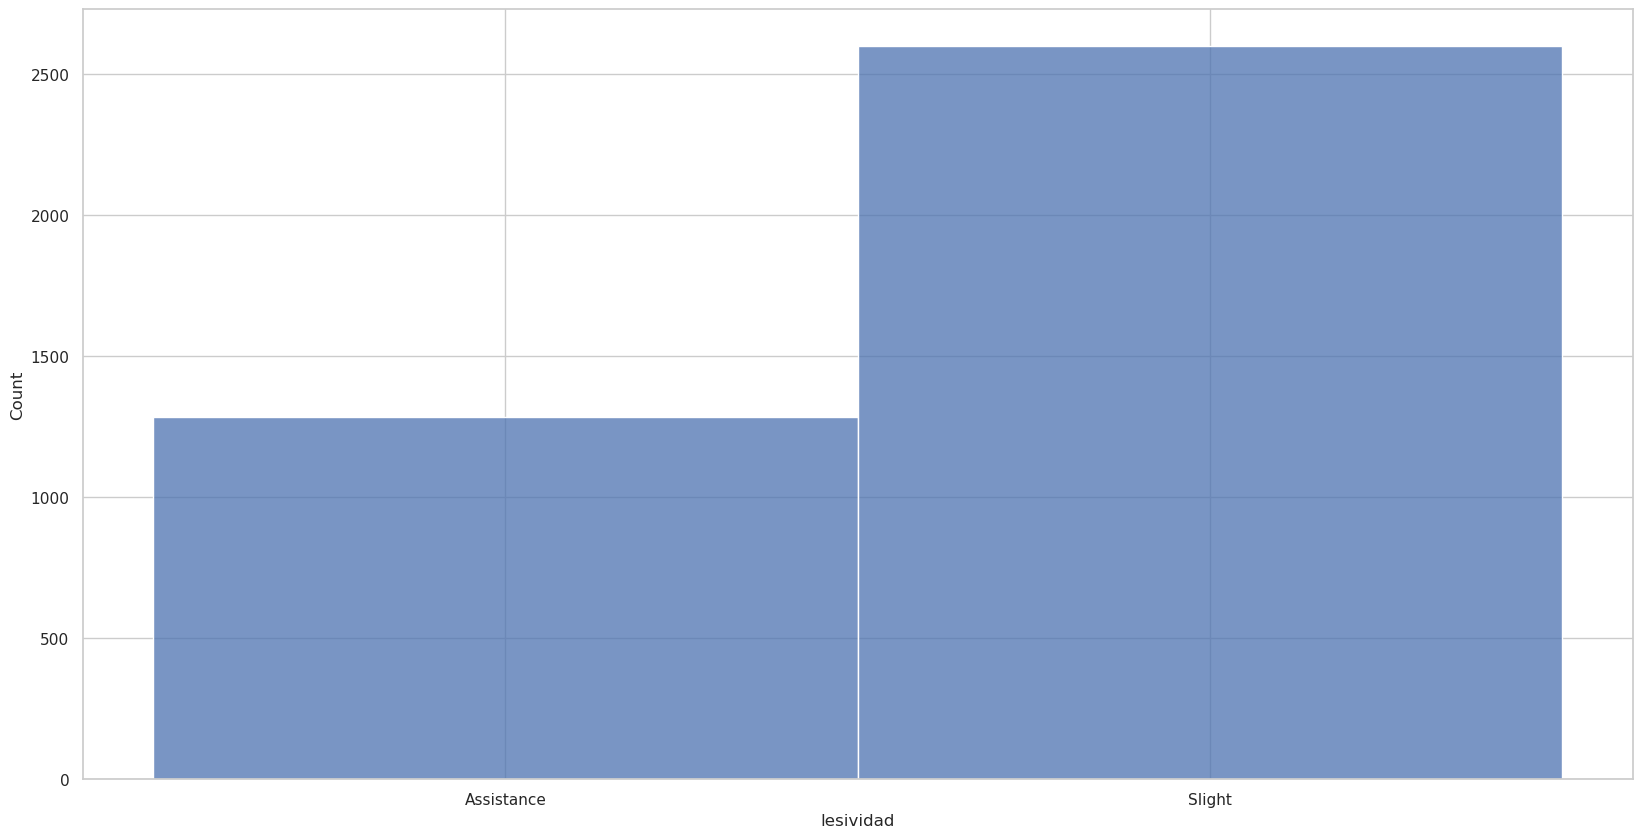

In [88]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=data_frame.lesividad,stat='count')
# plt.savefig('histograms_images/original.svg')
# one_hot_to_casualty(Y_train).value_counts()

## Split de datos

Histograma de desbalanceo

In [89]:
data_frame = data_frame.loc[:, ~data_frame.columns.isin(['Latitude', 'Longitude'])]
data_frame

,tipo_carretera,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,coordenada_x_utm,coordenada_y_utm,drogas_alcohol_positivo,vehiculos_implicados,Accident Time Sin,Accident Time Cos,dia_semana,semana_en_año
36065,17,11.0,5,1.0,5.0,1.0,3,1,Assistance,443767,4464719,2,2,-0.965926,0.258819,2,35
36066,17,11.0,5,1.0,5.0,1.0,3,2,Slight,443767,4464719,1,2,-0.965926,0.258819,2,35
50307,19,11.0,2,1.0,9.0,1.0,3,1,Slight,439229,4464807,2,3,0.866025,-0.500000,2,23
50308,19,11.0,2,1.0,4.0,1.0,3,1,Assistance,439229,4464807,2,3,0.866025,-0.500000,2,23
50309,19,11.0,2,1.0,4.0,2.0,3,1,Assistance,439229,4464807,2,3,0.866025,-0.500000,2,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,19,10.0,2,1.0,4.0,1.0,3,1,Slight,443111,4485054,2,2,-0.939693,0.342020,2,8
13963,19,10.0,2,1.0,4.0,1.0,2,1,Slight,443111,4485054,2,2,-0.766044,-0.642788,3,27
13964,19,10.0,2,1.0,5.0,1.0,3,1,Slight,443111,4485054,2,2,-0.766044,-0.642788,3,27
22045,19,10.0,3,1.0,1.0,1.0,3,1,Assistance,433574,4485681,2,1,0.258819,-0.965926,5,44


In [90]:
from sklearn.model_selection import train_test_split

data_frame['tipo_carretera'] = data_frame.tipo_carretera.astype(int)

train, test = train_test_split(data_frame, test_size=0.2, random_state = 2)
X_train = X_train_original = train.loc[:, ~train.columns.isin(['lesividad'])]


Y_train = Y_train_original = train['lesividad']

X_test = test.loc[:, ~test.columns.isin(['lesividad'])]
Y_test = test['lesividad']

/tmp/ipykernel_3880738/2311370365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['tipo_carretera'] = data_frame.tipo_carretera.astype(int)


lesividad
Slight        2070
Assistance    1039
Name: count, dtype: int64

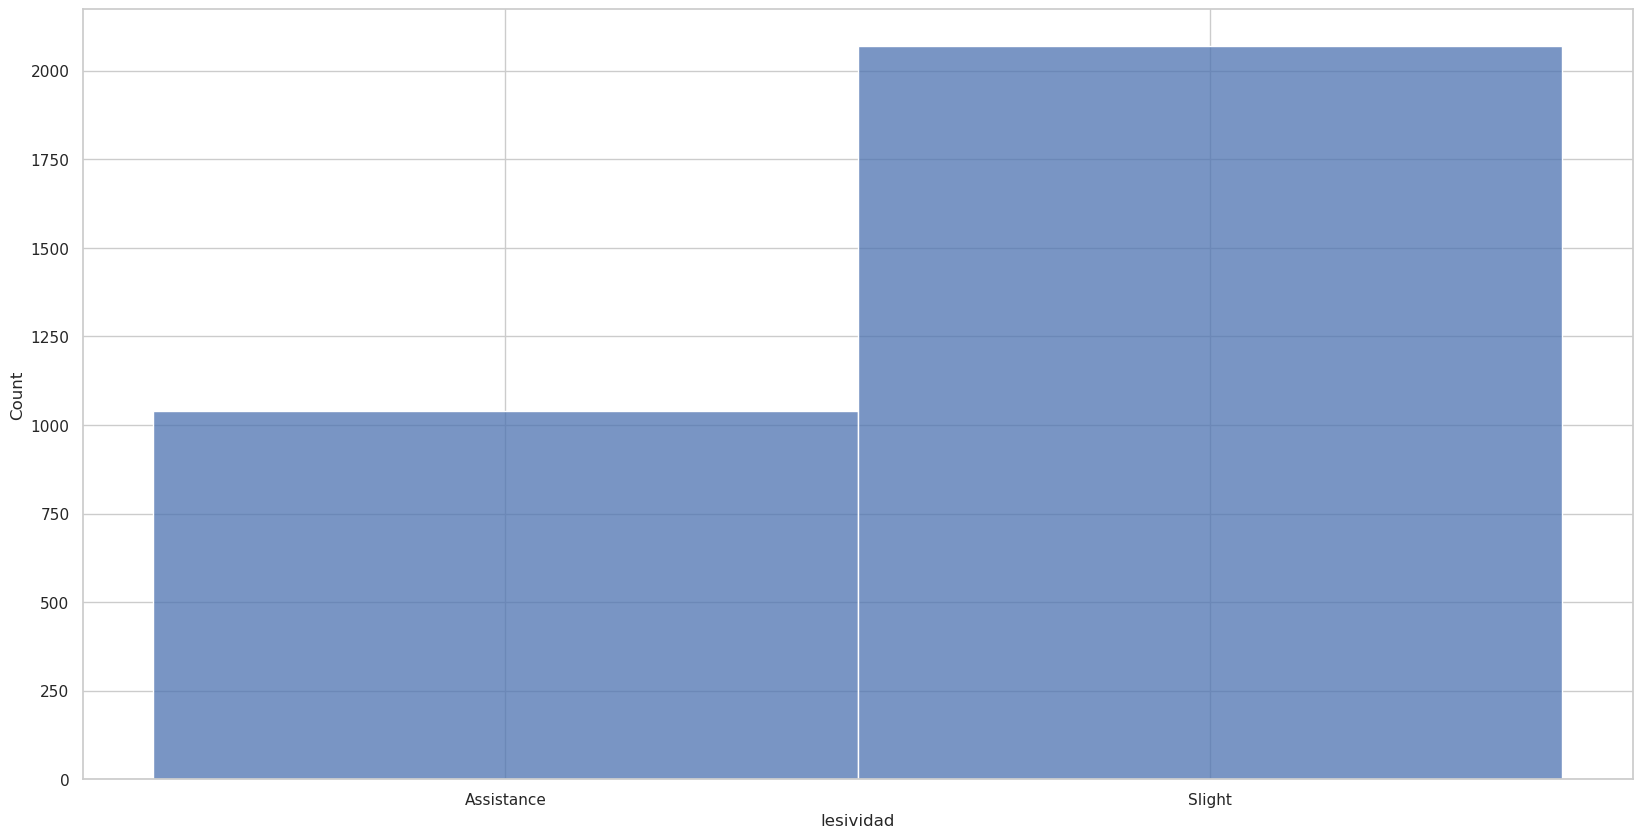

In [91]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=one_hot_to_casualty(Y_train),stat='count')
plt.savefig('histograms_images/original.svg')
one_hot_to_casualty(Y_train).value_counts()

In [92]:
# # FILE_NAME = f"{city_name}_calculated_weights.json"
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'

# feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

## Normalización de datos

In [93]:
X_train

,tipo_carretera,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,coordenada_x_utm,coordenada_y_utm,drogas_alcohol_positivo,vehiculos_implicados,Accident Time Sin,Accident Time Cos,dia_semana,semana_en_año
19053,19,15.0,0,1.0,5.0,1.0,3,1,441507,4474576,2,2,-0.382683,-0.923880,5,39
45565,18,16.0,2,1.0,5.0,2.0,2,2,438947,4469798,2,5,-0.382683,-0.923880,1,11
47412,19,0.0,4,1.0,5.0,1.0,3,1,440704,4475518,2,2,-0.939693,-0.342020,7,15
48067,0,4.0,4,1.0,9.0,2.0,2,2,443948,4475995,2,4,-0.216440,-0.976296,5,17
32062,19,1.0,6,1.0,5.0,1.0,4,1,435291,4471775,2,3,-0.953717,0.300706,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49949,19,10.0,4,1.0,9.0,1.0,3,1,441011,4480715,2,3,-0.608761,-0.793353,2,22
53477,17,3.0,2,1.0,5.0,1.0,3,1,444053,4473990,2,3,0.461749,-0.887011,1,31
3928,19,4.0,2,1.0,5.0,2.0,4,2,441768,4476325,2,2,0.216440,-0.976296,2,9
47242,19,6.0,2,1.0,3.0,1.0,3,1,441388,4476408,2,3,-0.939693,-0.342020,4,15


In [94]:
# X_train = X_train.astype(int)
# X_test  = X_test.astype(int)

# X_train_original = X_train_original.astype(int)

X_train = normalize_data(X_train)
X_train_original = normalize_data(X_train_original)
X_test  = normalize_data(X_test)

/tmp/ipykernel_3880738/4039655262.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df[column] = zscore(normalized_df[column])


## Oversampling de datos

In [95]:
from oversampling_methods.taspcnn_cGAN import cGAN

# cGAN(X_train,Y_train,10)
# cGAN.call()

### SMOTE-II

In [96]:
print('********** Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Assistance:  ', (Y_train == 'Assistance').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

print('********** Test **********')
print('Slight: ', (Y_test == 'Slight').sum())
print('Assistance:  ', (Y_test == 'Assistance').sum())
print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

********** Before OverSampling **********
Slight:  2070
Assistance:   1039

 Total X: 3109  Total Y: 3109 

********** After OverSampling **********
Slight:  2070
Assistance: 2070

 Total X:  4140  Total Y:  4140 

********** Test **********
Slight:  531
Assistance:   247

 Total X: 778  Total Y: 778 



lesividad
Assistance    2070
Slight        2070
Name: count, dtype: int64

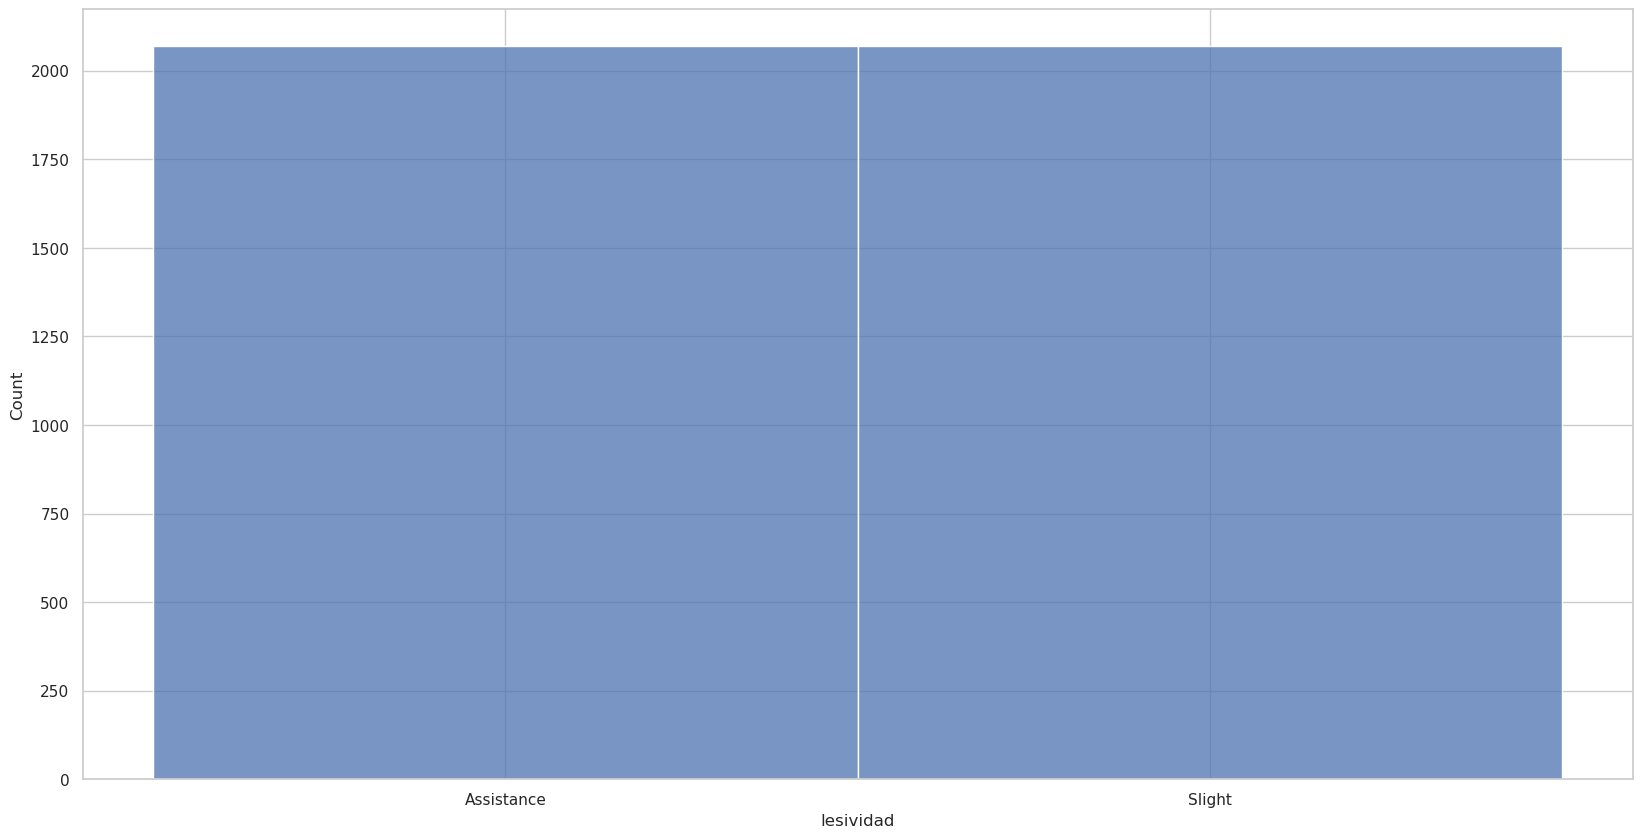

In [73]:
plt.figure(figsize=(20, 10))

sns.set_theme(style="whitegrid")
sns.histplot(data=one_hot_to_casualty(Y_train),stat='count')
plt.savefig('histograms_images/smote-ii.svg')
Y_train.value_counts()

## Downsampling de datos

### Two classes

In [74]:
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

slight_data  = test[test['lesividad'] == 'Slight']
serious_data = test[test['lesividad'] == 'Assistance']
# fatal_data   = test[test['lesividad'] == 'Fatal']

X_slight_downsampled = resample(slight_data,
                                replace = True,
                                n_samples = len(serious_data))

# X_serious_downsampled = resample(serious_data,
#                                  replace = True,
#                                  n_samples = len(fatal_data))


downsampled_dataset = pd.concat([X_slight_downsampled, serious_data])

downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)

X_train_downsampled = downsampled_train.loc[:, ~downsampled_train.columns.isin(['lesividad'])]
Y_train_downsampled = downsampled_train['lesividad']

X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin(['lesividad'])]
Y_test_downsampled = downsampled_test['lesividad']

### Three Classes

In [96]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state = 2)

## XGBoost

In [100]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from xgboost import XGBClassifier
import xgboost as xgb
import time


### Genético

In [101]:
if calculate_weights:
    Y_train_downsampled_copy = Y_train_downsampled.copy()
    Y_test_downsampled_copy  = Y_test_downsampled.copy()
    Y_test_copy = Y_test.copy()
    Y_val_copy  = Y_val.copy()
    Y_train_copy = Y_train.copy()

    Y_train_downsampled_onehot = casualty_to_one_hot(Y_train_downsampled_copy)
    Y_test_downsampled_onehot  = casualty_to_one_hot(Y_test_downsampled_copy)
    Y_val_onehot  = casualty_to_one_hot(Y_val_copy)
    Y_test_onehot  = casualty_to_one_hot(Y_test_copy)
    Y_train_onehot  = casualty_to_one_hot(Y_train_copy)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train,
                         label = Y_train_copy)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test_copy)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test_copy)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test_copy)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

2023-10-10 13:24:18.594518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 13:24:18.596557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 13:24:18.596651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-10 13:24:18.597878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.7147, best solution [ 0.07  6.   19.2 ]
This is number 1 generation
New population is 17
Best F1 score in the this iteration = 0.7237, best solution [0.07 6.   7.5 ]
This is number 2 generation
New population is 24
Best F1 score in the this iteration = 0.7365, best solution [0.06 5.   2.5 ]
This is number 3 generation
New population is 18
Best F1 score in the this iteration = 0.7391, best solution [0.01 6.   7.5 ]
This is number 4 generation
New population is 25
Best F1 score in the this iteration = 0.7391, best solution [0.01 4.   7.5 ]
This is number 5 generation
New population is 25
Best F1 score in the this iteration = 0.7391, best solution [0.01 4.   7.5 ]
This is number 6 generation
New population is 21
Best F1 score in the this iteration = 0.7391, best solution [0.01 4.   7.5 ]
This is number 7 generation
New population is 26
Best F1 score in the this iteration = 0.7391, best solution [0.01 4

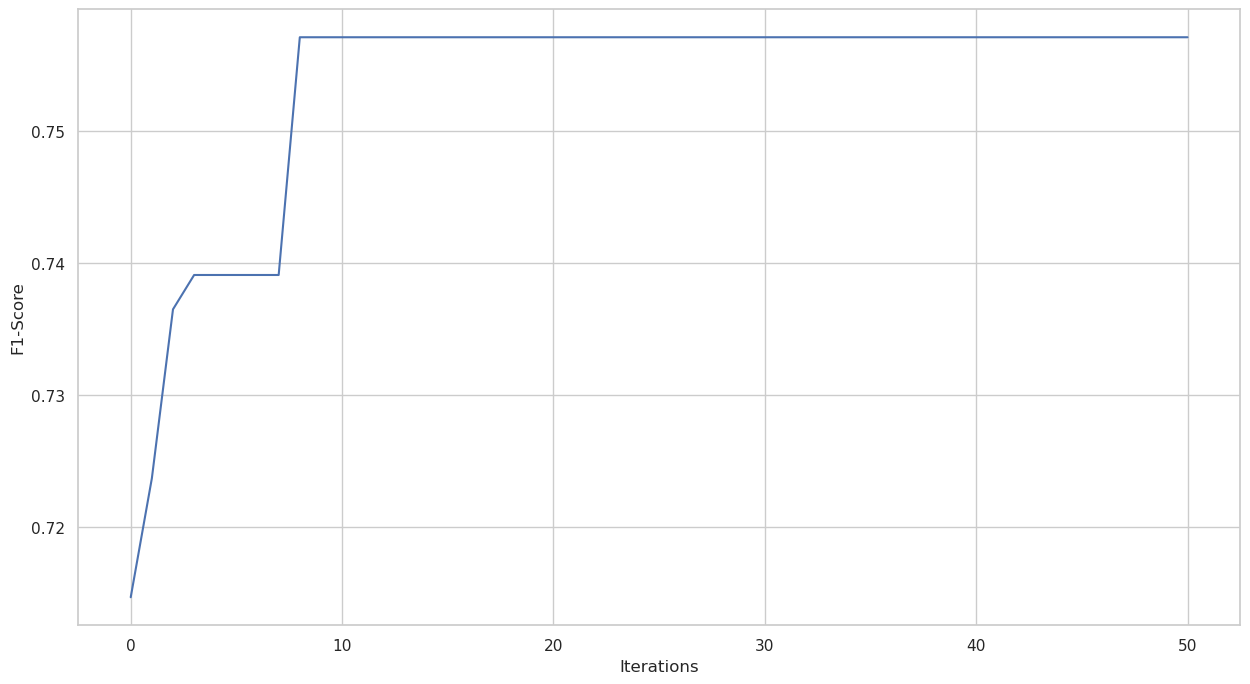

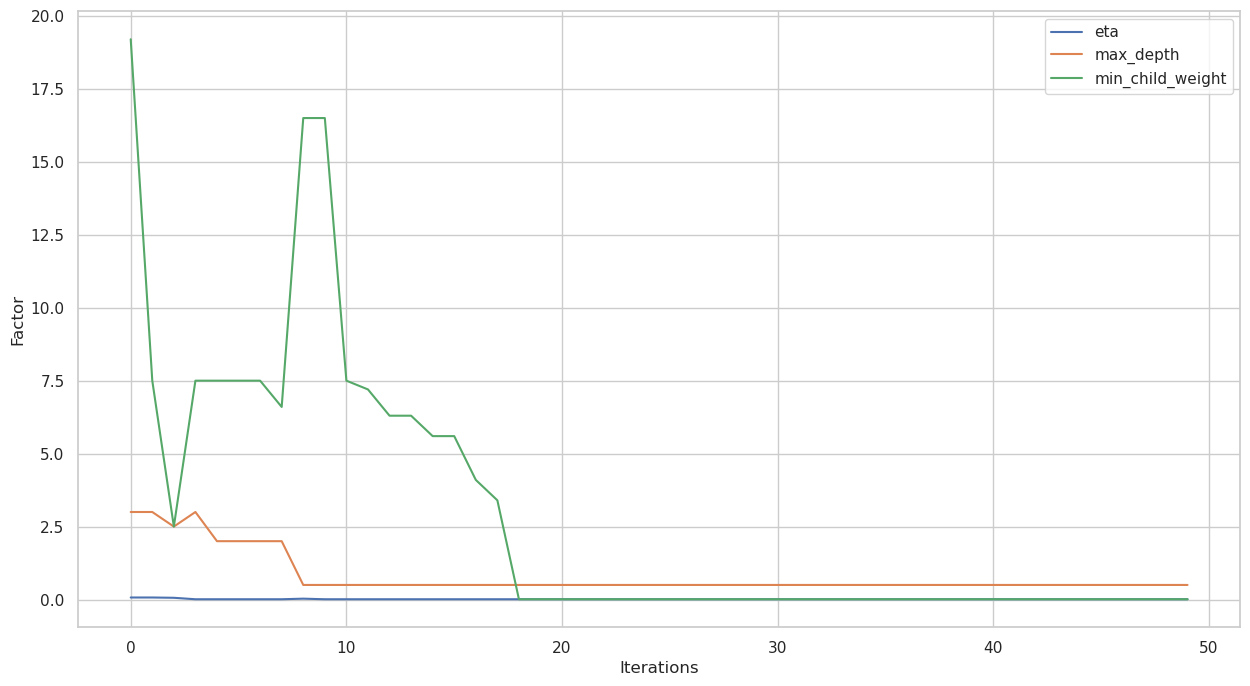

In [102]:
if calculate_weights and madrid:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')



In [103]:
# # best_solution_history_2 = best_solution_history.copy()
# # best_solution_history_2 =  np.append([[0, 0, 0]] ,best_solution_history)

FILE_NAME = "save2.json"

# # np.savetxt(FILE_NAME, best_solution_history, fmt='%s')
vector = load_json('./', FILE_NAME)
with open(FILE_NAME) as json_file:
    data = json.load(json_file)

In [104]:
np_array_to_append = [ [0.02, 4.0, 1.6099999999999999, 0.007437]]*30
np_array_to_append = np.asarray(np_array_to_append)
data = np.asarray(data)

In [105]:
data = np.concatenate([data, np_array_to_append])

In [106]:
new_array = []
for one_list in data:
    new_array.append(np.asarray(one_list))

new_array = np.asarray(new_array)

In [107]:
# for i in range(0,4):
#     print(i)

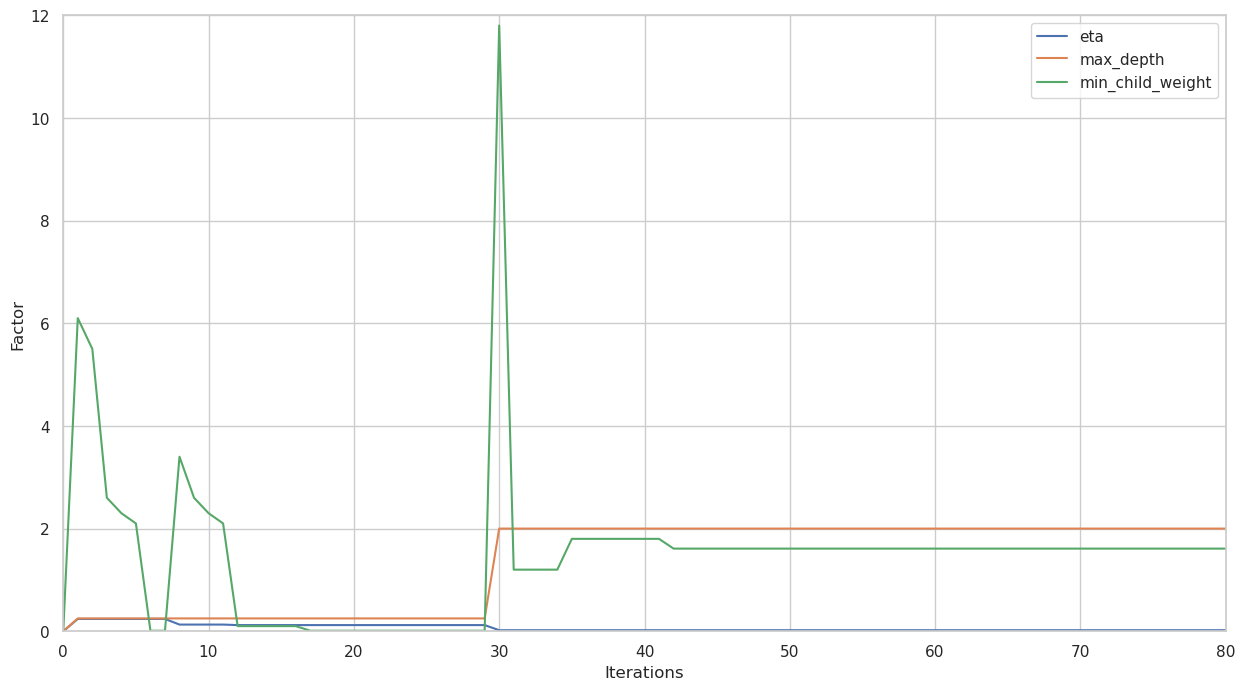

In [108]:
LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

vector = np.array(data).reshape(-1, 4)

vector[:,1] = vector[:,1]/2
vector[:,3] = vector[:,3]/100

plt.figure(figsize=(15, 8))
    
for i in range(0,3):
    plt.plot(vector[:,i])

    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.ylim(ymin=0, ymax=12)
    plt.xlim(xmin=0, xmax=80)

    plt.savefig('new.svg', dpi=300)

In [109]:
# data

### Hiperparámetros

- [Bayesian Optimization with HYPEROPT](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)

#### Carga hiperparámetros

In [110]:
if not calculate_weights and city:

    # FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"
    FILE_NAME = f"{city_name}_hyperparams2023-04-22-14:13:41.json"

    best_hyperparams = load_json(f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

# # # 0.875 GA
# # # 0.04, 1, 3.9, 900
# # # best_hyperparams = {}
# # # best_hyperparams['eta'] = 0.04
# # # best_hyperparams['max_depth'] = 1
# # # best_hyperparams['min_child_weight'] = 3.9
# # # best_hyperparams['n_estimators'] = 900

#### Escritura hiperparámetros

In [111]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)
    print(best_hyperparams)

{'eta': 0.01, 'max_depth': 1.0, 'min_child_weight': 0.01}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [112]:
# FILE_NAME = 'madrid_adapted_leeds_default_weights.json'
# # FILE_NAME = 'madrid_weights_no_roadClass.json'
FILE_NAME = f"madrid_weights_iii_paper.json"

feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

#### Cálculo de pesos de caracetrísticas

In [113]:
if calculate_weights and city:
    best_hyperparams['max_depth'] =  int(best_hyperparams['max_depth'])

    xgboost = XGBClassifier(**best_hyperparams,
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train_onehot)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)

In [114]:
feature_vector

{'Accident Features': {'feature_childs': ['coordenada_x_utm',
   'coordenada_y_utm',
   'distrito',
   'vehiculos_implicados'],
  'feature_weights': ['0.0', '0.0', '0.0', '0.0'],
  'wpi': 0.246134566},
 'Roadway Features': {'feature_childs': ['tipo_accidente'],
  'feature_weights': ['0.0'],
  'wpi': 0.04550401},
 'Environmental Features': {'feature_childs': ['estado_meteorológico'],
  'feature_weights': ['0.0'],
  'wpi': 0.07575404399999999},
 'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
  'feature_weights': ['0.6205972'],
  'wpi': 0.053042557},
 'Time Features': {'feature_childs': ['Accident Time Sin',
   'Accident Time Cos',
   'dia_semana',
   'semana_en_año'],
  'feature_weights': ['0.0', '0.0', '0.0', '0.0'],
  'wpi': 0.17765352},
 'Casualty Features': {'feature_childs': ['tipo_persona',
   'sexo',
   'rango_edad',
   'drogas_alcohol_positivo'],
  'feature_weights': ['0.37940282', '0.0', '0.0', '0.0'],
  'wpi': 0.5403722879999999}}

#### Visualización pesos calculados

{'tipo_vehiculo': 150.0, 'tipo_persona': 50.0}
[0.         0.         0.         0.         0.6205972  0.37940282
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
tipo_carretera 0.0
distrito 0.0
tipo_accidente 0.0
estado_meteorológico 0.0
tipo_vehiculo 0.6205972
tipo_persona 0.37940282
rango_edad 0.0
sexo 0.0
coordenada_x_utm 0.0
coordenada_y_utm 0.0
drogas_alcohol_positivo 0.0
vehiculos_implicados 0.0
Accident Time Sin 0.0
Accident Time Cos 0.0
dia_semana 0.0
semana_en_año 0.0


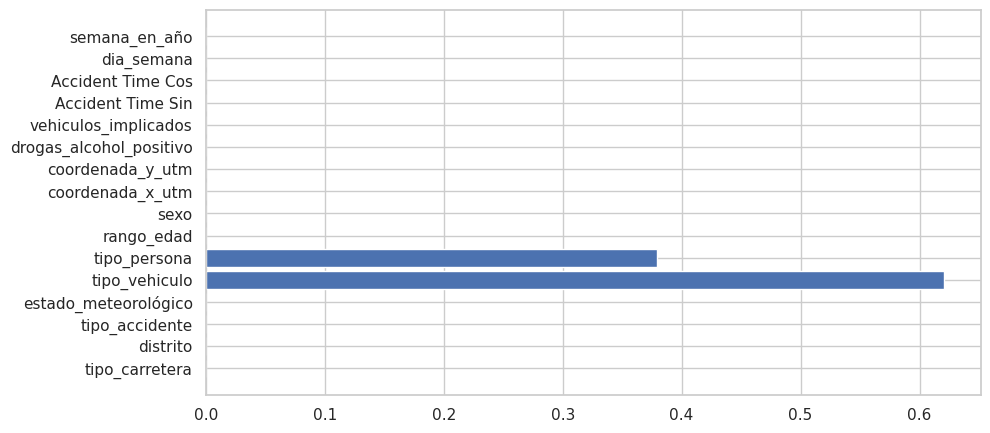

In [115]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train_downsampled.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    print(xgboost.feature_importances_)

    for column, weight in zip(X_train_downsampled.columns,xgboost.feature_importances_):
      print(column, weight)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train_downsampled, child_weights)

#### Escritura de pesos de características

- v5: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades no están en rango.
- v6: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades están en rango.
- v7: hiperparams, tipos de carretera tipificados por vía.

In [116]:
if calculate_weights and madrid:
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'default_calculated_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [117]:
if city:
    matrix_indexes = fv2gi(feature_vector)

In [118]:
matrix_indexes

{'tipo_vehiculo': [2, 2],
 'tipo_persona': [1, 2],
 'drogas_alcohol_positivo': [1, 1],
 'rango_edad': [1, 3],
 'sexo': [1, 0],
 'vehiculos_implicados': [3, 2],
 'distrito': [3, 1],
 'coordenada_y_utm': [3, 3],
 'coordenada_x_utm': [3, 0],
 'tipo_accidente': [0, 2],
 'estado_meteorológico': [4, 2],
 'semana_en_año': [-1, 2],
 'dia_semana': [-1, 1],
 'Accident Time Cos': [-1, 3],
 'Accident Time Sin': [-1, 0]}

## Construcción de imágenes

In [119]:
if city:
    max_dimension_x = len(feature_vector.keys())
    max_dimension_y = get_max_child_numbers(feature_vector)
    train_bgi = build_gray_images(X_train, max_dimension_x, max_dimension_y, matrix_indexes)
    train_original_bgi = build_gray_images(X_train_original, max_dimension_x, max_dimension_y, matrix_indexes)

    test_bgi  = build_gray_images(X_test, max_dimension_x, max_dimension_y, matrix_indexes)

3312
3109
778


## Reshape de imágenes

In [120]:
if city:

    train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)

    train_original_images = shape_images(X_data = X_train_original,
                                         gray_images = train_original_bgi)

    # val_images  = shape_images(X_data = X_val,
    #                            gray_images = val_bgi)

    test_images  = shape_images(X_data = X_test,
                                gray_images = test_bgi)

In [121]:
train_bgi[:,:,-1]

array([[ 0.00000000e+00,  0.00000000e+00,  1.05849388e+00,
         0.00000000e+00],
       [ 1.45343884e+00,  2.04670663e-01,  8.16326225e-01,
         1.65086027e-01],
       [ 0.00000000e+00,  0.00000000e+00, -1.34652032e-02,
         0.00000000e+00],
       [ 2.88842584e-01,  9.34376231e-02,  7.55882273e-01,
         2.31961221e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.05931071e+00,
         0.00000000e+00],
       [-9.85982367e-01, -1.15263208e-03,  1.77208622e+00,
         7.61771504e-01]])

/tmp/ipykernel_117992/1646512721.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


<Figure size 640x480 with 0 Axes>

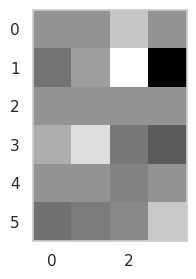

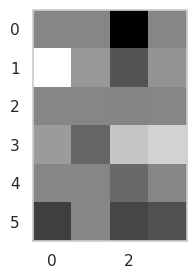

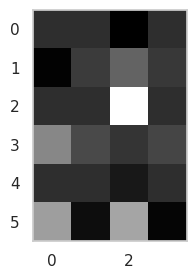

In [122]:
if city:

    sns.set_theme(style="whitegrid")
    plt.gray()
    for i in range(100,103):
        plt.figure(figsize=(3, 3))
        plt.grid(b=None)
        plt.imshow(train_bgi[:,:,i+6])
        # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
        plt.show()


## CT-GAN

In [123]:
train

,tipo_carretera,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,coordenada_x_utm,coordenada_y_utm,drogas_alcohol_positivo,vehiculos_implicados,Accident Time Sin,Accident Time Cos,dia_semana,semana_en_año
19053,19,15.0,0,1.0,5.0,1.0,3,1,Assistance,441507,4474576,2,2,-0.382683,-0.923880,5,39
45565,18,16.0,2,1.0,5.0,2.0,2,2,Slight,438947,4469798,2,5,-0.382683,-0.923880,1,11
47412,19,0.0,4,1.0,5.0,1.0,3,1,Slight,440704,4475518,2,2,-0.939693,-0.342020,7,15
48067,0,4.0,4,1.0,9.0,2.0,2,2,Slight,443948,4475995,2,4,-0.216440,-0.976296,5,17
32062,19,1.0,6,1.0,5.0,1.0,4,1,Slight,435291,4471775,2,3,-0.953717,0.300706,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49949,19,10.0,4,1.0,9.0,1.0,3,1,Slight,441011,4480715,2,3,-0.608761,-0.793353,2,22
53477,17,3.0,2,1.0,5.0,1.0,3,1,Slight,444053,4473990,2,3,0.461749,-0.887011,1,31
3928,19,4.0,2,1.0,5.0,2.0,4,2,Slight,441768,4476325,2,2,0.216440,-0.976296,2,9
47242,19,6.0,2,1.0,3.0,1.0,3,1,Slight,441388,4476408,2,3,-0.939693,-0.342020,4,15


In [124]:
transf = {
    'Slight': 0,
    'Assistance': 1
}   

train = train.replace(transf)

In [125]:
from ctgan import CTGAN

train['distrito'] = train['distrito'].astype(int)
train['estado_meteorológico'] = train['estado_meteorológico'].astype(int)
train['tipo_vehiculo'] = train['tipo_vehiculo'].astype(int)
train['tipo_persona'] = train['tipo_persona'].astype(int)
train['dia_semana'] = train['tipo_persona'].astype(int)
train['semana_en_año'] = train['tipo_persona'].astype(int)
train['coordenada_x_utm'] = train['coordenada_x_utm'].astype(float)
train['coordenada_y_utm'] = train['coordenada_y_utm'].astype(float)
train['lesividad'] = train['lesividad'].astype(int)

ctgan = CTGAN(epochs=10)
# ctgan.fit(train, ['lesividad'], epochs=1500)

# Create synthetic data
# synthetic_data = ctgan.sample(1000)

In [126]:
# synthetic_data.lesividad.value_counts()

## C-GAN

In [127]:
# batch_size = 64
# num_channels = 1
# num_classes = 2
# image_size = 8
# latent_dim = 32
# epochs = 150

In [128]:
# transf = {
#     'Slight': 0,
#     'Assistance': 1
# }   

# Y_train_categorical = Y_train.replace(transf)
# Y_test_categorical = Y_test.replace(transf)

In [129]:
# # We'll use all the available examples from both the training and test
# # sets.
# # (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# all_train = np.concatenate([train_images, test_images])
# npad = ((0, 0), (1, 2), (1, 2),(0,0))
# all_train = np.pad(all_train, pad_width=npad, mode='constant', constant_values=0)
# all_labels = np.concatenate([Y_train_categorical, Y_test_categorical])

# # Scale the pixel values to [0, 1] range, add a channel dimension to
# # the images, and one-hot encode the labels.
# all_train = all_train.astype("float32")
# all_train = np.reshape(all_train, (-1, 8, 8, 1))
# all_labels = keras.utils.to_categorical(all_labels, num_classes)

# # Create tf.data.Dataset.
# dataset = tf.data.Dataset.from_tensor_slices((all_train, all_labels))
# dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# print(f"Shape of training images: {all_train.shape}")
# print(f"Shape of training labels: {all_labels.shape}")


In [130]:
# from tensorflow import keras

# generator_in_channels = latent_dim + num_classes
# discriminator_in_channels = num_channels + num_classes
# print(generator_in_channels, discriminator_in_channels)

# # Create the discriminator.
# discriminator = keras.Sequential(
#     [
#         keras.layers.InputLayer((8, 8, discriminator_in_channels)),
#         layers.Conv2D(4, (2, 2), strides=(2, 2), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(4, (2, 2), strides=(3, 3), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.GlobalMaxPooling2D(),
#         layers.Dense(1),
#     ],
#     name="discriminator",
# )

# # Create the generator.
# generator = keras.Sequential(
#     [
#         keras.layers.InputLayer((generator_in_channels,)),
#         # We want to generate 128 + num_classes coefficients to reshape into a
#         # 7x7x(128 + num_classes) map.
#         layers.Dense(8 * 8 * generator_in_channels),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Reshape((2, 2, generator_in_channels)),
#         layers.Conv2DTranspose(16, (2,2), strides=(1, 1), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(16, (2,2), strides=(1, 1), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(32, (2,2), strides=(1, 1), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(1, (2, 2), padding="same", activation="sigmoid"),
#     ],
#     name="generator",
# )

# cond_gan = ConditionalGAN(
#     discriminator=discriminator, generator=generator, latent_dim=latent_dim
# )

# cond_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
# )

# cond_gan.fit(dataset, epochs=epochs)

In [131]:
# import imageio
# from tensorflow_docs.vis import embed

# # We first extract the trained generator from our Conditiona GAN.
# trained_gen = cond_gan.generator

# # Choose the number of intermediate images that would be generated in
# # between the interpolation + 2 (start and last images).
# num_interpolation = 2  # @param {type:"integer"}

# # Sample noise for the interpolation.
# interpolation_noise = tf.random.normal(shape=(1, latent_dim))
# interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
# interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


# def interpolate_class(first_number, second_number):
#     # Convert the start and end labels to one-hot encoded vectors.
#     first_label = keras.utils.to_categorical([first_number], num_classes)
#     second_label = keras.utils.to_categorical([second_number], num_classes)
#     first_label = tf.cast(first_label, tf.float32)
#     second_label = tf.cast(second_label, tf.float32)

#     # Calculate the interpolation vector between the two labels.
#     percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
#     percent_second_label = tf.cast(percent_second_label, tf.float32)
#     interpolation_labels = (
#         first_label * (1 - percent_second_label) + second_label * percent_second_label
#     )

#     # Combine the noise and the labels and run inference with the generator.
#     noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
#     fake = trained_gen.predict(noise_and_labels)
#     return fake


# start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
# end_class = 1  # @param {type:"slider", min:0, max:9, step:1}

# fake_images = interpolate_class(start_class, end_class)

# # fake_images *= 255.0
# converted_images = fake_images.astype(np.float)
# converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
# imageio.mimsave("animation.gif", converted_images, fps=1)
# embed.embed_file("animation.gif")


In [132]:
# plt.imshow(train_images[0])
# # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
# plt.show()

In [133]:
# plt.figure(figsize=(3, 3))
# plt.grid(b=None)
# plt.imshow(fake_images[0])
# # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
# plt.show()


In [134]:
# train_images = shape_images(X_data = X_train,
#                             gray_images = train_bgi)
# test_images  = shape_images(X_data = X_test,
#                             gray_images = test_bgi)

## Visualización de datos

In [135]:
# !conda install -c anaconda seaborn --y

### Matriz de correlación

In [136]:
# p

In [137]:
# data_frame = ['', '', '', '', 'Weather conditions', 'Vehicle']
# correlation_matrix(data_frame)

### PCA

In [138]:
# pca(X_train, X_test)

### TSNE

In [139]:
if city:
    n_samples = 150
    index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
    index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
    index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [140]:
if city:

    # Get same number of class samples from SMOTEII
    X_slight_train_tsne  = X_train.loc[index_slight]
    X_serious_train_tsne = X_train.loc[index_serious]
    X_fatal_train_tsne   = X_train.loc[index_fatal]

    X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

    Y_slight_train_tsne  = Y_train[index_slight]
    Y_serious_train_tsne = Y_train[index_serious]
    Y_fatal_train_tsne   = Y_train[index_fatal]

    Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [141]:
if city:

    n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

    index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
    index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
    index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [142]:
if city:

    # Get same number of class samples from original
    X_slight_clean_tsne  = X_train_original.loc[index_slight]
    X_serious_clean_tsne = X_train_original.loc[index_serious]
    X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

    X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

    Y_slight_clean_tsne  = Y_train_original[index_slight]
    Y_serious_clean_tsne = Y_train_original[index_serious]
    Y_fatal_clean_tsne   = Y_train_original[index_fatal]

    Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [143]:
if tsne and city:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_clean.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_clean.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [144]:
# # input_img = Input(shape=(25,))

# # # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
# # encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
# # encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

# # # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
# # decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
# # decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

# # # this model maps an input to its reconstruction
# # autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
# # autoencoder.summary()

# # autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas

# X_train = array_train_images
# X_test = array_test_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder.fit(X_train, X_train,
#                 epochs=120,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [145]:
# # create encoder model
# encoder = tf.keras.Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# # color=['red','green','blue']

# # for x, y, z, label in zip(xs, ys, zs, Y_test):
# #     c = color[int(label)]
# #     ax.text(x, y, z, label, backgroundcolor=c)
    
# # ax.set_xlim(xs.min(), xs.max())
# # ax.set_ylim(ys.min(), ys.max())
# # ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [146]:
if city:
    Y_train_onehot = casualty_to_one_hot(Y_train)
    Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
    # Y_val_onehot   = casualty_to_one_hot(Y_val)
    Y_test_onehot  = casualty_to_one_hot(Y_test)

    array_train_images = np.asarray(train_images)
    array_train_original_images = np.asarray(train_original_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

In [147]:
# if city:
#     array_val_images.shape

## Models

In [148]:
if city:
    array_train_images = np.asarray(train_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

    input_train_shape = (len(array_train_images), max_dimension_x, max_dimension_y, 1)
    # input_val_shape = (len(array_val_images), 5, 5, 1)
    input_test_shape  = (len(array_test_images), max_dimension_x, max_dimension_y, 1)

    array_train_images = array_train_images.reshape(input_train_shape)
    # array_val_images   = array_val_images.reshape(input_val_shape)
    array_test_images  = array_test_images.reshape(input_test_shape)

    Y_test_labels = one_hot_to_casualty(Y_test)

    from sklearn.utils import class_weight

    pesos = class_weight.compute_class_weight('balanced',
                                              classes = np.unique(Y_train_original),
                                              y = Y_train_original)


    print('\nPesos calculados:', pesos, '\n\n')


    # Keras espera un diccionario donde la clave sea el número de clase 
    # y el valor sea el peso calculado. 
    pesos = dict(enumerate(pesos))  


Pesos calculados: [0.75096618 1.49615014] 




In [149]:
import pickle
from joblib import dump, load

if city:

    times = pd.DataFrame()

### NB

In [150]:
if city:

    MODEL_NAME = MODELS_NAME[3]

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

    sns.reset_defaults()

#### Entrenamiento

In [151]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! logistic_regression in 0.0 (s)


#### Escritura del modelo

In [152]:
if city and train_nn and other_models:

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [153]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [154]:
if city and other_models:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.696   0.541     0.609  1653.000
Assistance        0.626   0.764     0.688  1659.000
accuracy          0.653   0.653     0.653     0.653
macro avg         0.661   0.653     0.648  3312.000
weighted avg      0.661   0.653     0.648  3312.000
              precision  recall  f1-score  support
Slight            0.867   0.567     0.686  531.000
Assistance        0.466   0.814     0.593  247.000
accuracy          0.645   0.645     0.645    0.645
macro avg         0.667   0.690     0.639  778.000
weighted avg      0.740   0.645     0.656  778.000


### SVC

In [199]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

if city:

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"
    MODEL_NAME = MODELS_NAME[1]

In [200]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! svc in 0.15 (s)


#### Escritura del modelo

In [201]:
if city and train_nn and other_models:

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [202]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [203]:
if city and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.896   0.857     0.876  1653.000
Assistance        0.863   0.901     0.881  1659.000
accuracy          0.879   0.879     0.879     0.879
macro avg         0.879   0.879     0.879  3312.000
weighted avg      0.879   0.879     0.879  3312.000
              precision  recall  f1-score  support
Slight            0.914   0.815     0.862  531.000
Assistance        0.678   0.834     0.748  247.000
accuracy          0.821   0.821     0.821    0.821
macro avg         0.796   0.825     0.805  778.000
weighted avg      0.839   0.821     0.826  778.000


### KNN

In [160]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

if city:

    MODEL_NAME = MODELS_NAME[2]


#### Entrenamiento

In [161]:
if city and other_models:
    knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

    start = time.time()

    knn.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! nb in 0.0 (s)


#### Escritura del modelo

In [162]:
# if city and train_nn and other_models:

#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#     dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [163]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [164]:
if city and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

              precision  recall  f1-score   support
Slight            0.748   0.635     0.687  1653.000
Assistance        0.684   0.787     0.732  1659.000
accuracy          0.711   0.711     0.711     0.711
macro avg         0.716   0.711     0.709  3312.000
weighted avg      0.716   0.711     0.709  3312.000
              precision  recall  f1-score  support
Slight            0.889   0.633     0.739  531.000
Assistance        0.512   0.830     0.634  247.000
accuracy          0.695   0.695     0.695    0.695
macro avg         0.701   0.731     0.686  778.000
weighted avg      0.769   0.695     0.706  778.000


### Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[3]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [166]:
# train_nn = True

In [167]:
if city and train_nn and other_models:
    start = time.time()

    logistic_regression = LogisticRegression()  
    logistic_regression = logistic_regression.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! logistic_regression in 0.01 (s)


#### Escritura del modelo

In [168]:
if city and train_nn and other_models:

    os.makedirs(MODEL_PATH, exist_ok = True)
    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [169]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [170]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = logistic_regression.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = logistic_regression.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.683   0.643     0.663  1653.000
Assistance        0.664   0.703     0.683  1659.000
accuracy          0.673   0.673     0.673     0.673
macro avg         0.674   0.673     0.673  3312.000
weighted avg      0.674   0.673     0.673  3312.000
              precision  recall  f1-score  support
Slight            0.867   0.661     0.750  531.000
Assistance        0.517   0.781     0.623  247.000
accuracy          0.699   0.699     0.699    0.699
macro avg         0.692   0.721     0.686  778.000
weighted avg      0.756   0.699     0.710  778.000


### Random Forest

In [171]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[4]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [172]:
if city and train_nn and other_models:
    start = time.time()

    xgboost = XGBClassifier()
    xgboost = XGBClassifier(n_estimators=2, max_depth=2, eta=0.01, min_child_weight= 6.8)
# "eta": 0.01, "max_depth": 2.0, "min_child_weight": 6.8}
    xgboost.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! random_forest in 0.01 (s)


#### Escritura del modelo

In [173]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [174]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [175]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = xgboost.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = xgboost.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.815   0.843     0.829  1653.000
Assistance        0.838   0.809     0.823  1659.000
accuracy          0.826   0.826     0.826     0.826
macro avg         0.826   0.826     0.826  3312.000
weighted avg      0.826   0.826     0.826  3312.000
              precision  recall  f1-score  support
Slight            0.899   0.635     0.744  531.000
Assistance        0.519   0.846     0.643  247.000
accuracy          0.702   0.702     0.702    0.702
macro avg         0.709   0.740     0.694  778.000
weighted avg      0.778   0.702     0.712  778.000


### MLP

In [176]:
from sklearn.neural_network import MLPClassifier

MODEL_NAME = MODELS_NAME[5]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [177]:
if city and train_nn and other_models:
    start = time.time()

    clf = MLPClassifier()

    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! mlp in 1.9 (s)


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Escritura del modelo

In [178]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [179]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [180]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_predicted = clf.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_predicted,
                                                         data = 'train')
    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.953   0.910     0.931  1653.000
Assistance        0.915   0.955     0.935  1659.000
accuracy          0.933   0.933     0.933     0.933
macro avg         0.934   0.933     0.933  3312.000
weighted avg      0.934   0.933     0.933  3312.000
              precision  recall  f1-score  support
Slight            0.890   0.825     0.856  531.000
Assistance        0.675   0.781     0.724  247.000
accuracy          0.811   0.811     0.811    0.811
macro avg         0.783   0.803     0.790  778.000
weighted avg      0.822   0.811     0.814  778.000


### Convolution 1D

In [282]:
if city:

    MODEL_NAME = MODELS_NAME[1]

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [162]:
Y_test_onehot.shape

TensorShape([602, 2])

In [ ]:
if city and train_nn and cnn1d:
    start = time.time()

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                 # class_weight = pesos,
                                 batch_size = 128,
                                 epochs = 100,
                                 shuffle = True,
                                 validation_data = (array_test_images, Y_test_onehot))
    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = pd.concat([times, model_time])

    history

NameError: name 'convolution_1d' is not defined

In [146]:
#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': 0})
#     times = times.append(model_time)
#     # wrap our model into a scikit-learn compatible classifier
#     print("[INFO] initializing model...")
#     model = KerasClassifier(build_fn=get_1d_conv, verbose=10)

#     # define a grid of the hyperparameter search space

#     # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
#     fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

#     dense  = [32, 64, 128, 256]

#     learnRate = [0.1, 1e-2, 1e-3, 1e-4]

#     batchSize = [32, 64]

#     epochs = [1]

#     # create a dictionary from the hyperparameter grid
#     grid = dict(
#         fm_one = fm_one,
#         fm_two = fm_two,
#         fm_three = fm_three,
#         fm_four = fm_four,
#         # fm_five = fm_five,
#         # fm_six = fm_six,
#         dense = dense,
#         learnRate=learnRate,
#         batch_size=batchSize,
#         epochs=epochs
#     )

#     # initialize a random search with a 3-fold cross-validation and then
#     # start the hyperparameter search process
#     print("[INFO] performing random search...")
#     searcher = RandomizedSearchCV(estimator = model,
#                                   n_iter = 1,
#                                   cv = 2,
#                                   param_distributions = grid,
#                                   scoring = 'f1_micro')

#     searchResults = searcher.fit(array_train_images, Y_train)

#     # summarize grid search information
#     bestScore = searchResults.best_score_
#     bestParams = searchResults.best_params_

#     print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

#     print("[INFO] evaluating the best model...")
#     taspcnn = bestModel = searchResults.best_estimator_
#     # accuracy = bestModel.score(array_test_images, Y_test)
#     # print("accuracy: {:.2f}%".format(accuracy * 100))

#     text_file = open(f"./CNN2D-{MODEL_TIMESTAMP}.txt", "w")
#     n = text_file.write(str(searchResults.cv_results_))
#     text_file.close()

#### Escritura del modelo

In [147]:
# if city and train_nn and cnn1d:

#     convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [148]:
if city and not train_nn and not laptop and cnn1d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

[INFO] evaluating network...
4/4 [==============================] - 0s 1ms/step


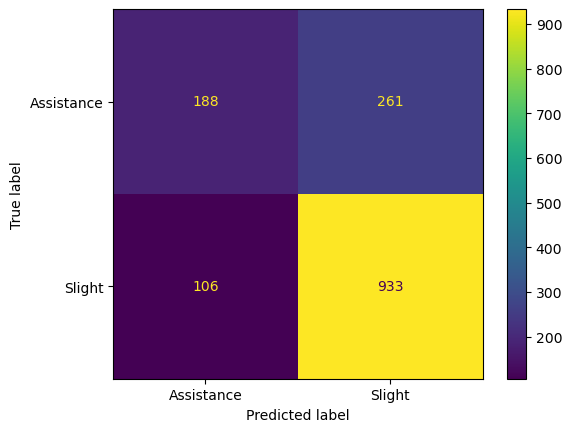

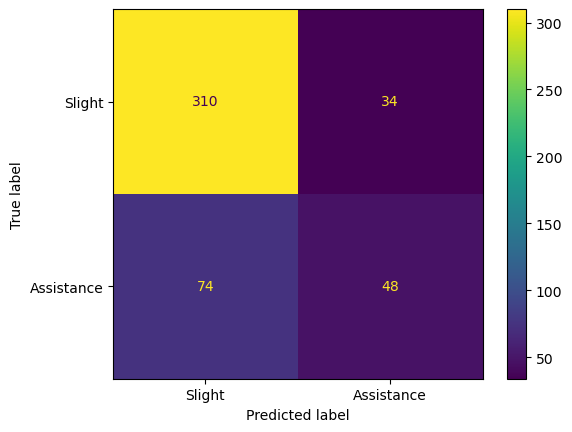

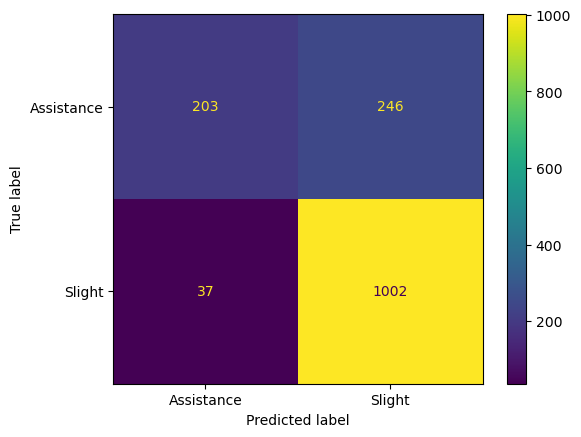

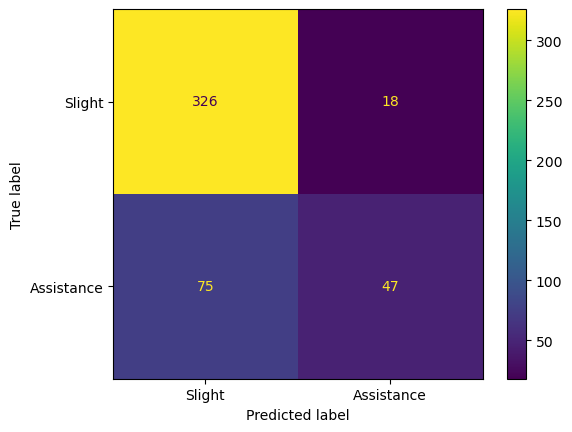

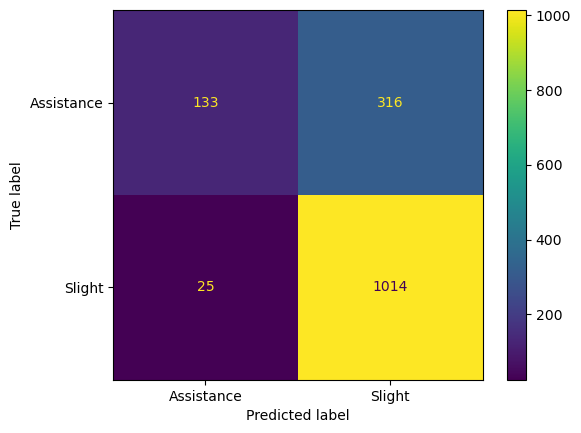

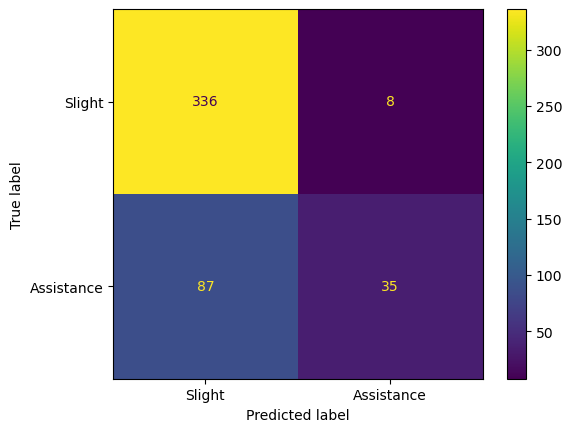

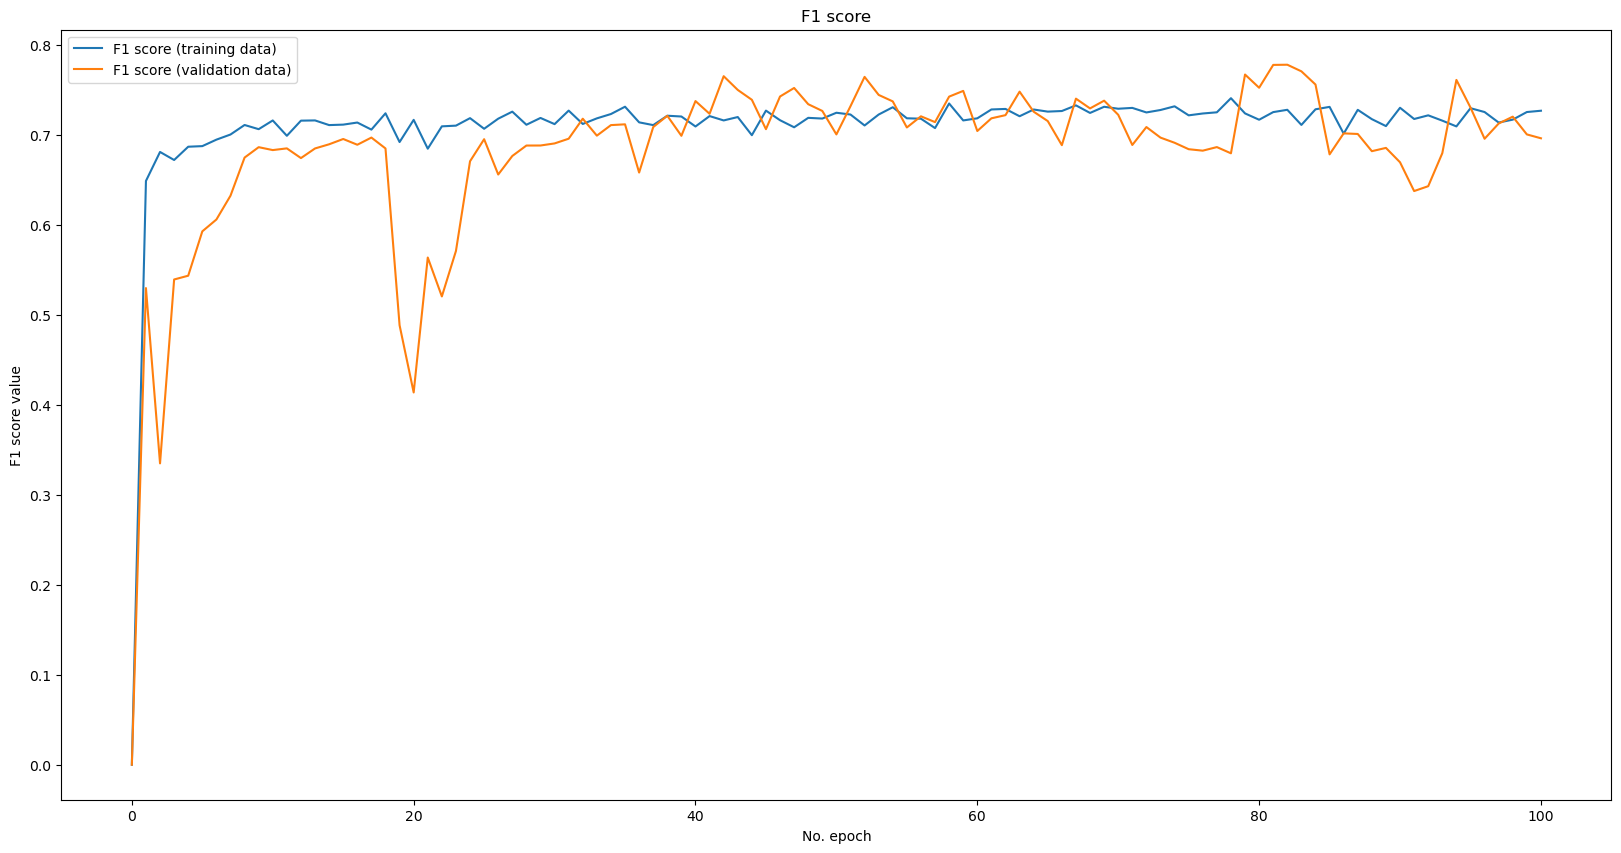

12/12 [==============================] - 0s 1ms/step
              precision  recall  f1-score   support
Assistance        0.886   0.742     0.808  1039.000
Slight            0.566   0.780     0.656   449.000
accuracy          0.753   0.753     0.753     0.753
macro avg         0.726   0.761     0.732  1488.000
weighted avg      0.790   0.753     0.762  1488.000
              precision  recall  f1-score  support
Slight            0.863   0.735     0.794  344.000
Assistance        0.474   0.672     0.556  122.000
accuracy          0.719   0.719     0.719    0.719
macro avg         0.669   0.704     0.675  466.000
weighted avg      0.762   0.719     0.732  466.000


In [149]:
if city and not laptop and cnn1d:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
                              f1_score_name = F1_SCORE_NAME,
                              history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images, batch_size = 128).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

### Convolution 2D

In [181]:
if city:

    MODEL_NAME = MODELS_NAME[7]

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-19-06:33:55.h5'

#### Entrenamiento

In [182]:
if city and train_nn:
    
    fm_one, fm_two, fm_three, fm_four = (256, 512, 512, 256)

    dense  = 32
    n_classes = len(Y_train.unique())

    learnRate = 0.00001

    learning_rate = 1e-05

    batchSize = 128

    start = time.time()

    tasp_cnn = get_tasp_cnn_o(max_dimension_x,
                              max_dimension_y,
                              fm_one = fm_one,
                              fm_two = fm_two,
                              fm_three = fm_three,
                              fm_four = fm_four,
                              dense = dense,
                              learning_rate = learning_rate,
                              num_classes = n_classes,
                              dropout = 0.2)

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = batchSize,
                           epochs = 50,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot))

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    history

    

Epoch 1/50


2023-10-10 13:27:21.707065: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-10-10 13:27:22.096229: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-10 13:27:22.097130: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-10 13:27:22.097141: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-10-10 13:27:22.097176: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

26/26 [==============================] - 2s 21ms/step - loss: 0.6185 - f1_score: 0.7136 - val_loss: 0.6874 - val_f1_score: 0.6667
Epoch 2/50
26/26 [==============================] - 0s 8ms/step - loss: 0.4212 - f1_score: 0.7960 - val_loss: 0.6968 - val_f1_score: 0.6667
Epoch 3/50
26/26 [==============================] - 0s 7ms/step - loss: 0.3411 - f1_score: 0.8268 - val_loss: 0.7134 - val_f1_score: 0.6667
Epoch 4/50
26/26 [==============================] - 0s 7ms/step - loss: 0.2848 - f1_score: 0.8609 - val_loss: 0.7300 - val_f1_score: 0.6667
Epoch 5/50
26/26 [==============================] - 0s 7ms/step - loss: 0.2372 - f1_score: 0.8877 - val_loss: 0.7594 - val_f1_score: 0.6667
Epoch 6/50
26/26 [==============================] - 0s 8ms/step - loss: 0.2080 - f1_score: 0.9078 - val_loss: 0.8158 - val_f1_score: 0.6667
Epoch 7/50
26/26 [==============================] - 0s 8ms/step - loss: 0.1749 - f1_score: 0.9266 - val_loss: 0.8770 - val_f1_score: 0.6667
Epoch 8/50
26/26 [============

In [183]:
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV


# model_time = pd.DataFrame({'city': [city_name],
#                            'model': [MODEL_NAME],
#                            'time': 0})
# times = times.append(model_time)
# # wrap our model into a scikit-learn compatible classifier
# print("[INFO] initializing model...")
# model = KerasClassifier(build_fn=get_tasp_cnn, verbose=10)

# # define a grid of the hyperparameter search space

# # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
# fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

# dense  = [8, 16, 32, 64, 128, 256]

# learnRate = [0.1, 1e-2, 1e-3, 1e-4]

# batchSize = [128]

# epochs = [50]

# num_classes = [2]

# # create a dictionary from the hyperparameter grid
# grid = dict(
# 	fm_one = fm_one,
#     fm_two = fm_two,
#     fm_three = fm_three,
#     fm_four = fm_four,
#     # fm_five = fm_five,
#     # fm_six = fm_six,
#     dense = dense,
#     num_classes=num_classes,
# 	learnRate=learnRate,
# 	batch_size=batchSize,
# 	epochs=epochs
# )

# # initialize a random search with a 3-fold cross-validation and then
# # start the hyperparameter search process
# print("[INFO] performing random search...")
# searcher = RandomizedSearchCV(estimator = model,
#                               n_iter = 150,
#                               cv = 3,
#                               param_distributions = grid,
#                               scoring = 'f1_micro',
#                               verbose = 0)

# searchResults = searcher.fit(array_train_images, Y_train)

# # summarize grid search information
# bestScore = searchResults.best_score_
# bestParams = searchResults.best_params_

# print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

# print("[INFO] evaluating the best model...")
# tasp_cnn = bestModel = searchResults.best_estimator_
# # accuracy = bestModel.score(array_test_images, Y_test)
# # print("accuracy: {:.2f}%".format(accuracy * 100))

# text_file = open(f"./madrid-CNN2D-{MODEL_TIMESTAMP}.txt", "w")
# n = text_file.write(str(searchResults.cv_results_))
# text_file.close()

#### Escritura del modelo

In [184]:
# tasp_cnn = bestModel = searchResults.best_estimator_


In [185]:
if city and train_nn:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}_1.h5"

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [186]:
if city and not train_nn and not laptop:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [187]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [188]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [189]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

In [190]:
if city and not laptop:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)
    rep = {'Slight': 0, 'Assistance': 1}
    Y_train.replace(rep, inplace=True)
    Y_test.replace(rep, inplace=True)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}_1.svg"

        # plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
        #                       f1_score_name = F1_SCORE_NAME,
        #                       history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images, batch_size = 128).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


[INFO] evaluating network...
26/26 [==============================] - 0s 1ms/step
              precision  recall  f1-score   support
Slight            0.994   0.994     0.994  1653.000
Assistance        0.994   0.994     0.994  1659.000
accuracy          0.994   0.994     0.994     0.994
macro avg         0.994   0.994     0.994  3312.000
weighted avg      0.994   0.994     0.994  3312.000
              precision  recall  f1-score  support
Slight            0.928   0.876     0.901  531.000
Assistance        0.762   0.854     0.805  247.000
accuracy          0.869   0.869     0.869    0.869
macro avg         0.845   0.865     0.853  778.000
weighted avg      0.875   0.869     0.871  778.000


In [205]:
# history.history

## AutoML

In [206]:
# MODEL_NAME = MODELS_NAME[3]

In [207]:
# tasp_cnn.save(root_path + 'madrid_model_XGBOOST_predicted.h5')

In [208]:
# import autokeras as ak

# # clf = ak.ImageClassifier(num_classes = 3,
# #                          loss='categorical_crossentropy',
# #                          metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
# #                          overwrite = True,
# #                          tuner= 'bayesian',
# #                          max_trials = 20,
# #                          max_model_size = 3000000
# #                         )
# clf = ak.StructuredDataClassifier(num_classes = 3,
#                              loss='categorical_crossentropy',
#                              metrics = [tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold = 0.1)],
#                              overwrite = True,
#                              tuner= 'bayesian',
#                              max_trials = 20
#                         )

# clf.fit(array_train_images,
#         np.asarray(Y_train),
#         epochs = 100,
#         batch_size = 128,
#         validation_data = (array_test_images, np.asarray(Y_test)))

# best_auto_model = clf.export_model()
# print(best_auto_model.summary())

### Escritura del modelo

In [209]:
# MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
# MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

# best_auto_model.save(MODEL_PATH + MODEL_FILE_NAME)

### Resultados

In [210]:
# Y_predicted = best_auto_model.predict(x = array_test_images, batch_size = 128).argmax(axis = 1)

# F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
# F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

# # plot_f1_score(f1_score_path = F1_SCORE_PATH,
# #               f1_score_name = F1_SCORE_NAME,
# #               history = history)

# print("[INFO] evaluating network...")

# REPORT_PATH = f"{REPORTS_PATH}{MODEL_NAME}/"
# REPORT_NAME  = f"{city_name}_{MODEL_NAME}_report_{MODEL_TIMESTAMP}.csv"

# plot_classification_report(path = REPORT_PATH,
#                            file_name = REPORT_NAME,
#                            y_true = Y_test,
#                            y_predicted = Y_predicted)


# CONFUSION_MATRIX_PATH = f"{CONFUSIONS_MATRIX_PATH}{MODEL_NAME}/"
# CONFUSION_MATRIX_NAME  = f"{city_name}_{MODEL_NAME}_confusion_matrix_{MODEL_TIMESTAMP}.svg"

# plot_confusion_matrix(path = CONFUSION_MATRIX_PATH,
#                       file_name = CONFUSION_MATRIX_NAME,
#                       y_true = Y_test,
#                       y_predicted = Y_predicted)

## AutoML

In [211]:
# MODEL_NAME = MODELS_NAME[3]

# Data Summary

## Models times plot

### Sort

In [191]:
times = times.sort_values('time')

### Save csv

In [192]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [193]:
# LOAD_PATH = f"{REPORTS_TIMES_PATH}2022-05-23-15:28:04.csv"
# times = pd.read_csv(LOAD_PATH)

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

In [22]:
from src.mixins.plot import make_reports_summary
from src.mixins.plot import make_f1_score_barplot

city_name = 'Victoria'
victoria = True

reports_summary, splits, cities = make_reports_summary(times, city_name, MODEL_TIMESTAMP, REPORTS_PATH, REPORTS_SUMMARY_PATH, leeds, madrid, UK)
make_f1_score_barplot(reports_summary, splits, city_name, cities, MODEL_TIMESTAMP, REPORTS_SUMMARY_PATH, leeds, madrid, UK)

NameError: name 'times' is not defined

## Models scores plot

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


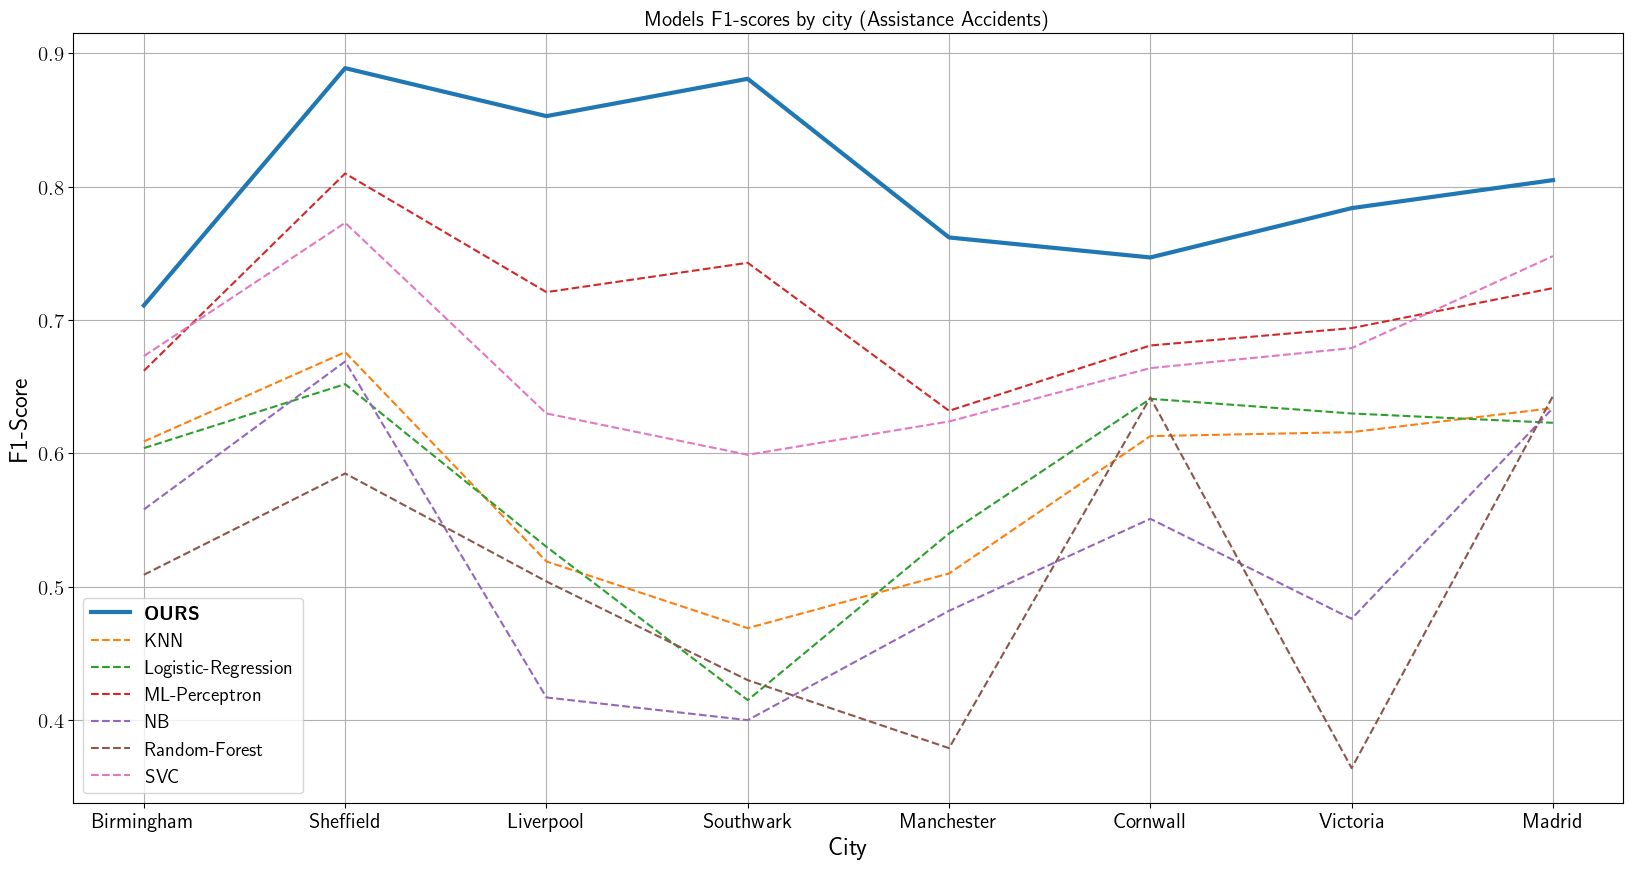

In [44]:
from src.mixins.plot import plot_time_series

plot_time_series()